In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0276

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 515ms/step - loss: 0.0194
Average validation loss: 0.562171459197998
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - loss: 0.0194 - val_loss: 0.5622
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - loss: 0.0120 - val_loss: 0.5622
Average validation loss: 0.43626314401626587
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 509ms/step - loss: 0.0120 - val_loss: 0.4992
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 510ms/step - loss: 0.0086 - val_loss: 0.4992
Average validation loss: 0.3985280990600586
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step - loss: 0.0086 - val_loss: 0.4657
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 806ms/step - loss: 8.1998e-06
Average validation loss: 0.7461595088243484
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 815ms/step - loss: 8.1998e-06 - val_loss: 0.7462
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 799ms/step - loss: 8.6919e-06 - val_loss: 0.7462
Average validation loss: 0.5864625871181488
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 814ms/step - loss: 8.6919e-06 - val_loss: 0.6663
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 781ms/step - loss: 8.8140e-06 - val_loss: 0.6663
Average validation loss: 0.13184582069516182
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 792ms/step - loss: 8.8140e-06 - val_loss: 0.4882
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 846ms/step - loss: 1.9516e-06
Average validation loss: 0.05460788495838642
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 858ms/step - loss: 1.9516e-06 - val_loss: 0.0546
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 799ms/step - loss: 2.2936e-06 - val_loss: 0.0546
Average validation loss: 0.11853947614630063
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 809ms/step - loss: 2.2936e-06 - val_loss: 0.0866
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 781ms/step - loss: 2.4558e-06 - val_loss: 0.0866
Average validation loss: 0.07191230356693268
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 793ms/step - loss: 2.4558e-06 - val_loss: 0.0817
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 776ms/step - loss: 2.6195e-06 - val_loss: 0.0817
Average validation loss: 0.05990604404360056
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 788ms/step - loss: 2.6195e-06 - val_loss: 0.0762
Epoch 5/1

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 782ms/step - loss: 4.8142e-07
Average validation loss: 0.03623122884891927
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 792ms/step - loss: 4.8142e-07 - val_loss: 0.0362
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 806ms/step - loss: 4.2781e-07 - val_loss: 0.0362
Average validation loss: 0.02669177216012031
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 816ms/step - loss: 4.2781e-07 - val_loss: 0.0315
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 798ms/step - loss: 3.7634e-07 - val_loss: 0.0315
Average validation loss: 0.026571998721919954
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 809ms/step - loss: 3.7634e-07 - val_loss: 0.0298
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\we

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 812ms/step - loss: 3.2303e-07
Average validation loss: 0.025673025380820037
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 823ms/step - loss: 3.2303e-07 - val_loss: 0.0257
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 780ms/step - loss: 3.0953e-07 - val_loss: 0.0257
Average validation loss: 0.0358092431910336
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 790ms/step - loss: 3.0953e-07 - val_loss: 0.0307
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 813ms/step - loss: 3.0713e-07 - val_loss: 0.0307
Average validation loss: 0.030273667769506574
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 824ms/step - loss: 3.0713e-07 - val_loss: 0.0306
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 782ms/step - loss: 2.8622e-07 - val_loss: 0.0306
Average validation loss: 0.027546933200210334
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 792ms/step - loss: 2.8622e-07 - val_loss: 0.0298
Epoch 5

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 790ms/step - loss: 5.8697e-07
Average validation loss: 0.017003060434944928
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 800ms/step - loss: 5.8697e-07 - val_loss: 0.0170
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 778ms/step - loss: 4.3352e-07 - val_loss: 0.0170
Average validation loss: 0.014995705433345089
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 4.3352e-07 - val_loss: 0.0160
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 781ms/step - loss: 3.5139e-07 - val_loss: 0.0160
Average validation loss: 0.021048573583054047
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 792ms/step - loss: 3.5139e-07 - val_loss: 0.0177
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 781ms/step - loss: 2.98

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 778ms/step - loss: 4.6089e-07
Average validation loss: 0.023338325275108217
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 789ms/step - loss: 4.6089e-07 - val_loss: 0.0233
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 772ms/step - loss: 3.7226e-07 - val_loss: 0.0233
Average validation loss: 0.017755945678800344
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 783ms/step - loss: 3.7226e-07 - val_loss: 0.0205
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 772ms/step - loss: 3.0669e-07 - val_loss: 0.0205
Average validation loss: 0.02479162879753858
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 783ms/step - loss: 3.0669e-07 - val_loss: 0.0220
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 125s 779ms/step - loss: 2.55

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 773ms/step - loss: 2.9762e-07
Average validation loss: 0.018111503003941227
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 784ms/step - loss: 2.9762e-07 - val_loss: 0.0181
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 799ms/step - loss: 2.2771e-07 - val_loss: 0.0181
Average validation loss: 0.01455371353464822
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 809ms/step - loss: 2.2771e-07 - val_loss: 0.0163
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 113s 771ms/step - loss: 1.7772e-07 - val_loss: 0.0163
Average validation loss: 0.01624609318484242
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 782ms/step - loss: 1.7772e-07 - val_loss: 0.0163
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 153s 823ms/step - loss: 1.5

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 792ms/step - loss: 1.6237e-07
Average validation loss: 0.023093313244836672
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 804ms/step - loss: 1.6237e-07 - val_loss: 0.0231
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 800ms/step - loss: 1.2811e-07 - val_loss: 0.0231
Average validation loss: 0.026039961758734926
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 812ms/step - loss: 1.2811e-07 - val_loss: 0.0246
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 815ms/step - loss: 1.0571e-07 - val_loss: 0.0246
Average validation loss: 0.016765636524983814
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 826ms/step - loss: 1.0571e-07 - val_loss: 0.0220
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 793ms/step - loss: 9

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 796ms/step - loss: 1.5404e-07
Average validation loss: 0.015176314307609573
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 808ms/step - loss: 1.5404e-07 - val_loss: 0.0152
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 777ms/step - loss: 1.0448e-07 - val_loss: 0.0152
Average validation loss: 0.020676138141425326
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 789ms/step - loss: 1.0448e-07 - val_loss: 0.0179
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 780ms/step - loss: 8.3794e-08 - val_loss: 0.0179
Average validation loss: 0.019611204421380535
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 791ms/step - loss: 8.3794e-08 - val_loss: 0.0185
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 203s 780ms/step - loss: 7.1138e-08 - val_loss: 0.0185
Average validation loss: 0.01952215822529979
64/64 ━━━━━━━━━━━━━━━━━━━━ 204s 792ms/step - loss: 7.1138e-08 - val_loss: 0.0187


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 777ms/step - loss: 3.8817e-08
Average validation loss: 0.019453470908855606
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 788ms/step - loss: 3.8817e-08 - val_loss: 0.0195
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 781ms/step - loss: 4.4147e-08 - val_loss: 0.0195
Average validation loss: 0.019637509026021387
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 792ms/step - loss: 4.4147e-08 - val_loss: 0.0195
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 787ms/step - loss: 3.9008e-08 - val_loss: 0.0195
Average validation loss: 0.017422828668107588
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 800ms/step - loss: 3.9008e-08 - val_loss: 0.0188
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 227s 771ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 777ms/step - loss: 6.0489e-08
Average validation loss: 0.015754210989689453
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 788ms/step - loss: 6.0489e-08 - val_loss: 0.0158
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 792ms/step - loss: 4.5107e-08 - val_loss: 0.0158
Average validation loss: 0.012792387447552756
80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 803ms/step - loss: 4.5107e-08 - val_loss: 0.0143
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 190s 782ms/step - loss: 3.8429e-08 - val_loss: 0.0143
Average validation loss: 0.0135543265088927
80/80 ━━━━━━━━━━━━━━━━━━━━ 191s 793ms/step - loss: 3.8429e-08 - val_loss: 0.0140
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 254s 791ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 801ms/step - loss: 1.0923e-07
Average validation loss: 0.03293283607733125
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 812ms/step - loss: 1.0923e-07 - val_loss: 0.0329
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 782ms/step - loss: 7.8893e-08 - val_loss: 0.0329
Average validation loss: 0.023543196672108024
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 792ms/step - loss: 7.8893e-08 - val_loss: 0.0282
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 230s 787ms/step - loss: 6.2889e-08 - val_loss: 0.0282
Average validation loss: 0.024938151967944577
96/96 ━━━━━━━━━━━━━━━━━━━━ 231s 798ms/step - loss: 6.2889e-08 - val_loss: 0.0271
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 307s 798ms/step - loss

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 787ms/step - loss: 7.6089e-07
Average validation loss: 0.017065759391213457
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 798ms/step - loss: 7.6089e-07 - val_loss: 0.0171
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 190s 787ms/step - loss: 4.7233e-07 - val_loss: 0.0171
Average validation loss: 0.03205550277295212
120/120 ━━━━━━━━━━━━━━━━━━━━ 192s 798ms/step - loss: 4.7233e-07 - val_loss: 0.0246
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 286s 787ms/step - loss: 3.5966e-07 - val_loss: 0.0246
Average validation loss: 0.017546572691450515
120/120 ━━━━━━━━━━━━━━━━━━━━ 287s 798ms/step - loss: 3.5966e-07 - val_loss: 0.0222
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 382s 786ms/step - loss: 2.9049e-07 - val_loss: 0.0222
Average validation loss: 0.017496205369631448
120/120 ━━━━━━━━━━━━━━━━━━━━ 383s 797ms/step - loss: 2.9049e-07 - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 787ms/step - loss: 2.5588e-07
Average validation loss: 0.01969217004564901
144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 799ms/step - loss: 2.5588e-07 - val_loss: 0.0197
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 228s 784ms/step - loss: 1.8971e-07 - val_loss: 0.0197
Average validation loss: 0.025264690125671525
144/144 ━━━━━━━━━━━━━━━━━━━━ 230s 795ms/step - loss: 1.8971e-07 - val_loss: 0.0225
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 342s 778ms/step - loss: 1.5987e-07 - val_loss: 0.0225
Average validation loss: 0.02784117774313523
144/144 ━━━━━━━━━━━━━━━━━━━━ 343s 790ms/step - loss: 1.5987e-07 - val_loss: 0.0243
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 456s 780ms/step - loss: 1.4155e-07 - val_loss: 0.0243
Average validation loss: 0.022220377965519827
144/144 ━━━━━━━━━━━━━━━━━━━━ 457s 791ms/step - loss: 1.4155e-07 -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 779ms/step - loss: 1.3617e-06
Average validation loss: 0.06331661021104082
160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 791ms/step - loss: 1.3617e-06 - val_loss: 0.0633
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 251s 778ms/step - loss: 1.2715e-06 - val_loss: 0.0633
Average validation loss: 0.04326967392116785
160/160 ━━━━━━━━━━━━━━━━━━━━ 253s 789ms/step - loss: 1.2715e-06 - val_loss: 0.0533
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 377s 775ms/step - loss: 1.2411e-06 - val_loss: 0.0533
Average validation loss: 0.06797871236922219
160/160 ━━━━━━━━━━━━━━━━━━━━ 378s 786ms/step - loss: 1.2411e-06 - val_loss: 0.0582
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 504s 783

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 158s 791ms/step - loss: 2.2468e-07
Average validation loss: 0.02536913560645189
200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 802ms/step - loss: 2.2468e-07 - val_loss: 0.0254
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 319s 792ms/step - loss: 1.7820e-07 - val_loss: 0.0254
Average validation loss: 0.02564536971389316
200/200 ━━━━━━━━━━━━━━━━━━━━ 321s 803ms/step - loss: 1.7820e-07 - val_loss: 0.0255
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 477s 781ms/step - loss: 1.5502e-07 - val_loss: 0.0255
Average validation loss: 0.02574576029262971
200/200 ━━━━━━━━━━━━━━━━━━━━ 479s 792ms/step - loss: 1.5502e-07 - val_loss: 0.0256
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 637s 787ms/step - loss: 1.4519e-07 - val_loss: 0.0256
Average validation loss: 0.030879912679665722
200/200 ━━━━━━━━━━━━━━━━━━━━ 639s 798ms/step - loss: 1.4519e-07 - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 187s 781ms/step - loss: 6.9003e-08
Average validation loss: 0.022347339817376147
240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 792ms/step - loss: 6.9003e-08 - val_loss: 0.0223
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 378s 782ms/step - loss: 6.3995e-08 - val_loss: 0.0223
Average validation loss: 0.01935840364882703
240/240 ━━━━━━━━━━━━━━━━━━━━ 380s 793ms/step - loss: 6.3995e-08 - val_loss: 0.0209
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 564s 766ms/step - loss: 5.8949e-08 - val_loss: 0.0209
Average validation loss: 0.022043033979358976
240/240 ━━━━━━━━━━━━━━━━━━━━ 567s 777ms/step - loss: 5.8949e-08 - val_loss: 0.0212
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 754s 7

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.18856028959155083, 0.18354556370526554, 0.05828263177846869, 0.030066613174276426, 0.018598628262989223, 0.01809974484106836, 0.017310312175308352, 0.013941554771154187, 0.013807250882382504, 0.014215880849878886, 0.014787827241234484, 0.014904475775256285, 0.01884059443756996, 0.019245385552872904, 0.03770633401460348, 0.039284360142451985, 0.026647096387088096, 0.0214054597635051]
std_val_losses =  [0.10628534095519312, 0.17708791886472924, 0.037332150184677386, 0.016608813205909574, 0.006515073023316461, 0.008261014717620408, 0.0041540959340679775, 0.004056873367914875, 0.0041670647679103974, 0.004559037810534139, 0.003145308610746535, 0.002592610725505588, 0.006249872186832033, 0.0031644270856406465, 0.026882232037800675, 0.011708590545355701, 0.0053917647514299775, 0.003971129524373079]


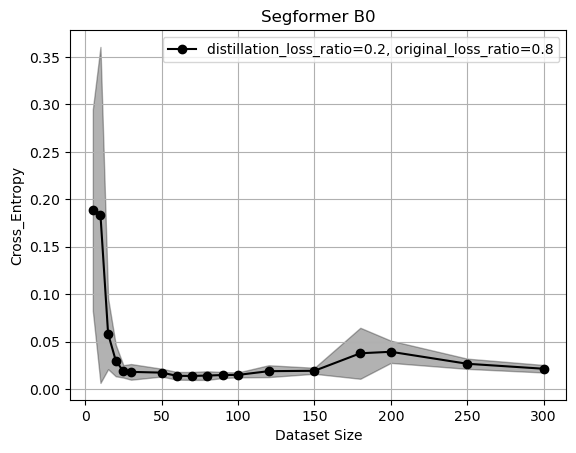

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()